### Simulation Investigation into Conditional Trend Filtering and Changepoint Detection on High-Frequency Price Process

Jason Bohne

Jason.bohne@stonybrook.edu

Applied Math and Stats Ph.D. Student 

Under Supervision of Professor Pawel Polak



In [1]:
import sys
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt


path='/home/jbohne/sbu/'
sys.path.append(f'{path}taq_db/TAQ-Query-Scripts/data')
sys.path.append(f'{path}research/Adaptive_Signal_Estimation_Private')

from kernel_methods.Kernel_Smoother import KernelSmoother
from kernel_methods.MomKernel_Smoother import MomKernelSmoother

from matrix_algorithms.difference_matrix import Difference_Matrix
from matrix_algorithms.time_difference_matrix import Time_Difference_Matrix

from trend_filtering.adaptive_tf import adaptive_tf
from trend_filtering.cv_tf import cross_validation
from trend_filtering.helpers import compute_lambda_max,extract_cp

from dynamic_programming.dp_recursion import dp_solver
from dynamic_programming.cp_model_selection import generalized_cross_validation
from dynamic_programming.spline_fit import fit_linear_spline

from simulations.Conditional_Simulator import ConditionalSimulator
from simulations.Sampler import Sampler

### Prep Data

- First minute seconds of trade data for AAPL after open across availble U.S. equity exchanges
- Benchmark model for seconds however can extend to any time interval
- Results in ~1400 observations
- Preprocessed and cleaned to remove trades executed before open

In [2]:
trades=pd.read_csv(f'{path}taq_db/TAQ-Query-Scripts/data/AAPL_trades.csv',index_col=0).dropna()
trades=trades[trades.index < "2020-01-02 09:55:30"]
trades=trades[trades.index> "2020-01-02 09:30:00"]
trades.index=pd.to_datetime(trades.index)


trades['Trade_Price']=np.log(trades['Trade_Price'])

trades=trades[trades['Trade_Volume'] <100000]

In [3]:
trades=trades[:500]

### Step 1; Generate Prior and Smooth using KDE

- In our analysis trade volume will be used as a prior for changes in underlying price trend however any discrete series can be utilized (realized volatility)
- Normalize time of prior to be incremented in total seconds


Smoothing Technique (KDE)
- Nonparametric method which smooths candidate point $ x_i$ as a weighted average of all observations $x_j$ where weights $w_i$ are a function of their distance in time from candidate point
- Gaussian Kernels specify function of a normal density
- Optimal bandwidth is selected either through Scott's or Silvermans.

In [25]:
original_index=trades['Trade_Volume'].index
volume_index=np.fmin(0.01,[(i -original_index[0]).total_seconds() for i in original_index])
volume_prior=trades['Trade_Volume'].values

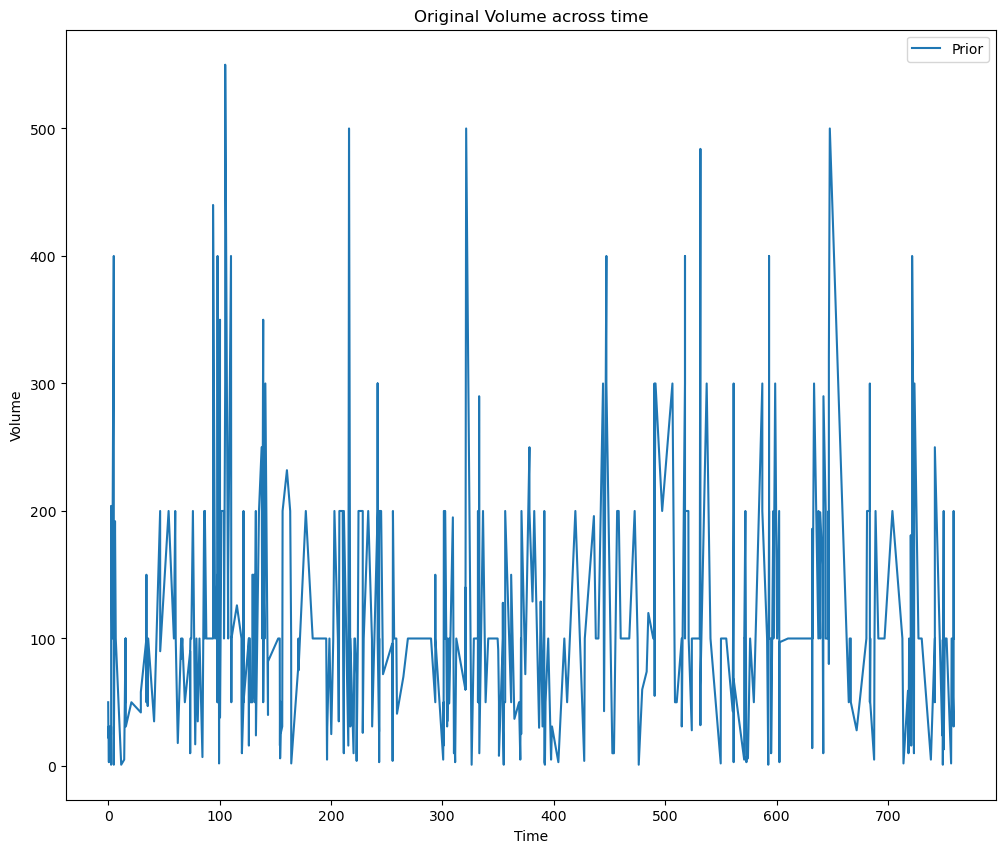

In [5]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Original Volume across time")
plt.ylabel("Volume")
plt.xlabel("Time")
plt.plot(volume_index,volume_prior,label="Prior")
plt.legend()

In [6]:
smooth_kernel=KernelSmoother(volume_index,volume_prior,bandwidth_style=0)
fitted_kernel_matirx=smooth_kernel.fit()


In [7]:
smooth=smooth_kernel.smooth_series(fitted_kernel_matirx)

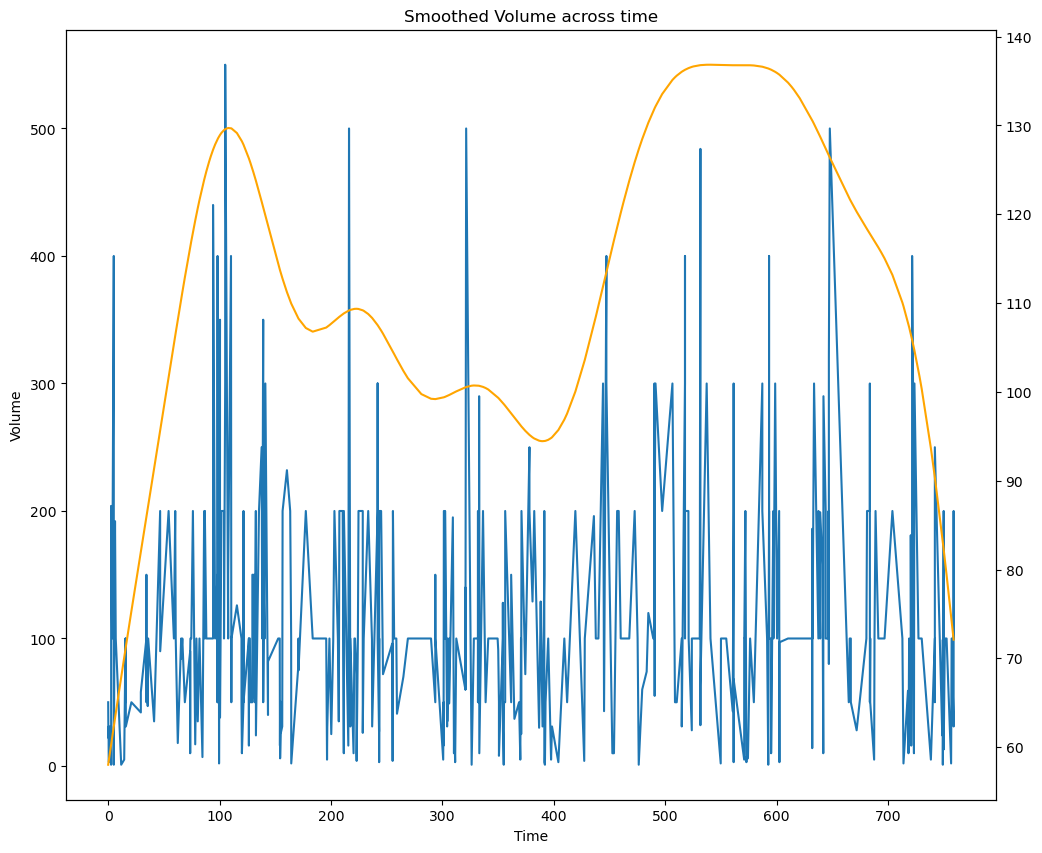

In [8]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Smoothed Volume across time")
plt.ylabel("Volume")
plt.xlabel("Time")
ax.plot(volume_index,volume_prior,label="Original")
ax2=ax.twinx()
ax2.plot(volume_index,smooth,label="Optimal Smoothed Volume",color='orange')

# ax2.plot(volume_index,mom_smooth_estimate,label="Optimal MOM Smoothed Volume",color='green')
# ax.legend()
# ax2.legend()


### Step 2 ; Simulate True Underlying Trend (Piecewise Linear and Constant)

- Label true changepoints based on some criteria (max, local peaks, etc.)
- Each change in underlying series is sampled from a normal distribution of variance prespecified 
- Interpretation is that most consecutive values will be piecewise linear with small noise; with sparse jumps arising from larger variance 


In [9]:
prior=volume_prior
sim_style='piecewise_linear'
label_style='k_maxima'
k_points=10
n_sims=10000
underling_dist='normal'

sim=ConditionalSimulator(prior,sim_style,label_style,k_points,underling_dist,n_sims=n_sims)

In [10]:
import time

start=time.time()

true_linear=sim.simulate()
eval_true_linear=sim.evaluate_within_sample(sim.cp_index,true_linear)

end=time.time()
print(f"Simulation and Evaluation for {n_sims} piecewise linear samples took {end-start} seconds")

Simulation and Evaluation for 10000 piecewise linear samples took 0.09280753135681152 seconds


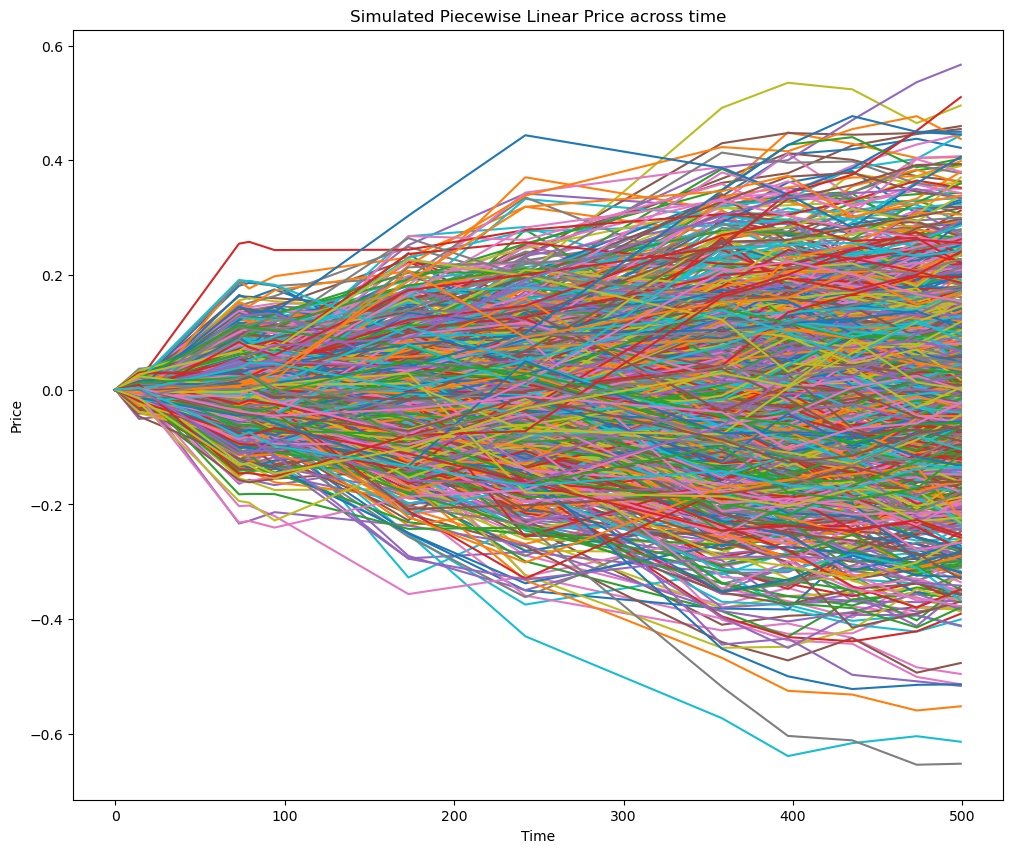

In [11]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Simulated Piecewise Linear Price across time")
plt.ylabel("Price")
plt.xlabel("Time")

for i in range(0,1000):
    ax.plot(eval_true_linear[i,:])


In [12]:
prior=volume_prior
sim_style='piecewise_constant'
label_style='k_maxima'
k_points=10
n_sims=10000
underling_dist='normal'

sim=ConditionalSimulator(prior,sim_style,label_style,k_points,underling_dist,n_sims=n_sims)

In [13]:
import time

start=time.time()

true_constant=sim.simulate()
eval_true_constant=sim.evaluate_within_sample(sim.cp_index,true_constant)

end=time.time()
print(f"Simulation and Evaluation for {n_sims} piecewise constant samples took {end-start} seconds")

Simulation and Evaluation for 10000 piecewise constant samples took 0.12006855010986328 seconds


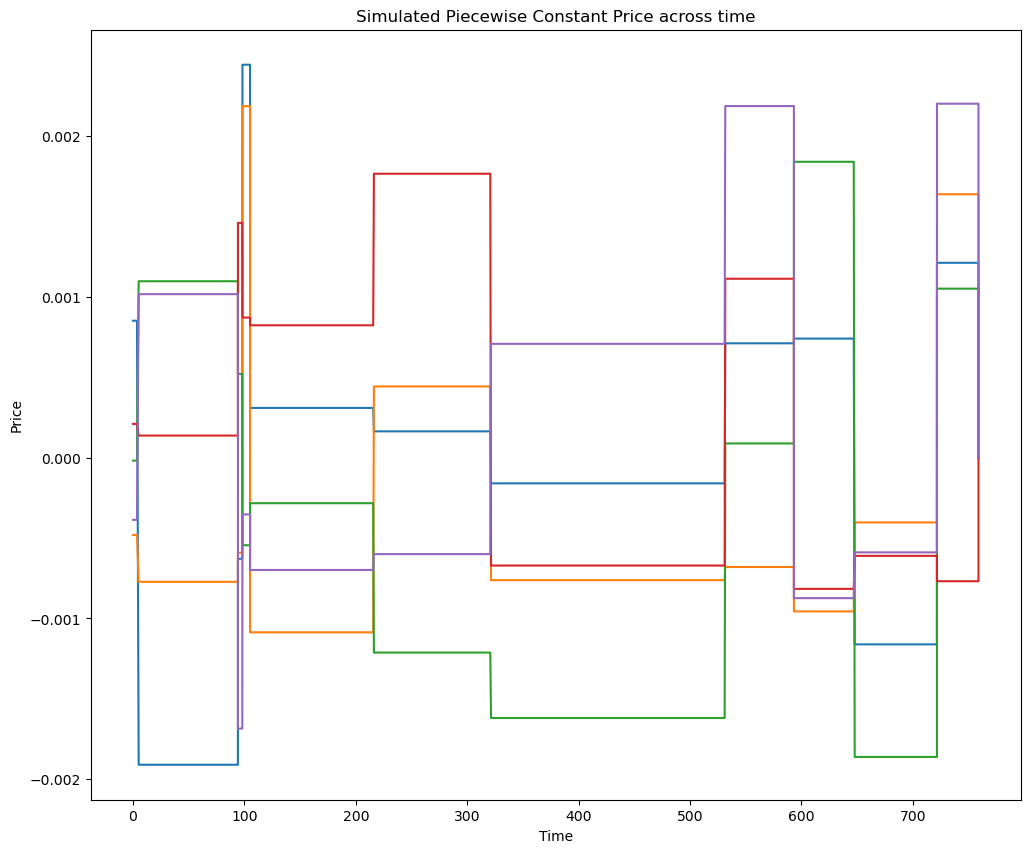

In [14]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Simulated Piecewise Constant Price across time")
plt.ylabel("Price")
plt.xlabel("Time")

for i in range(0,5):
    ax.plot(volume_index,eval_true_constant[i,:])

### Step 4; Utilize Sampler Class to generate bulk samples off true processes

In [15]:
dist='normal'

sampler=Sampler(distribution=dist)

n_samples=10000
scale=0.1
start=time.time()

samples=sampler.sample(eval_true_linear,scale=scale)

end=time.time()
print(f"Sampling {n_samples} samples from a {dist} distribution took {end-start} seconds")

Sampling 10000 samples from a normal distribution took 0.2550199031829834 seconds


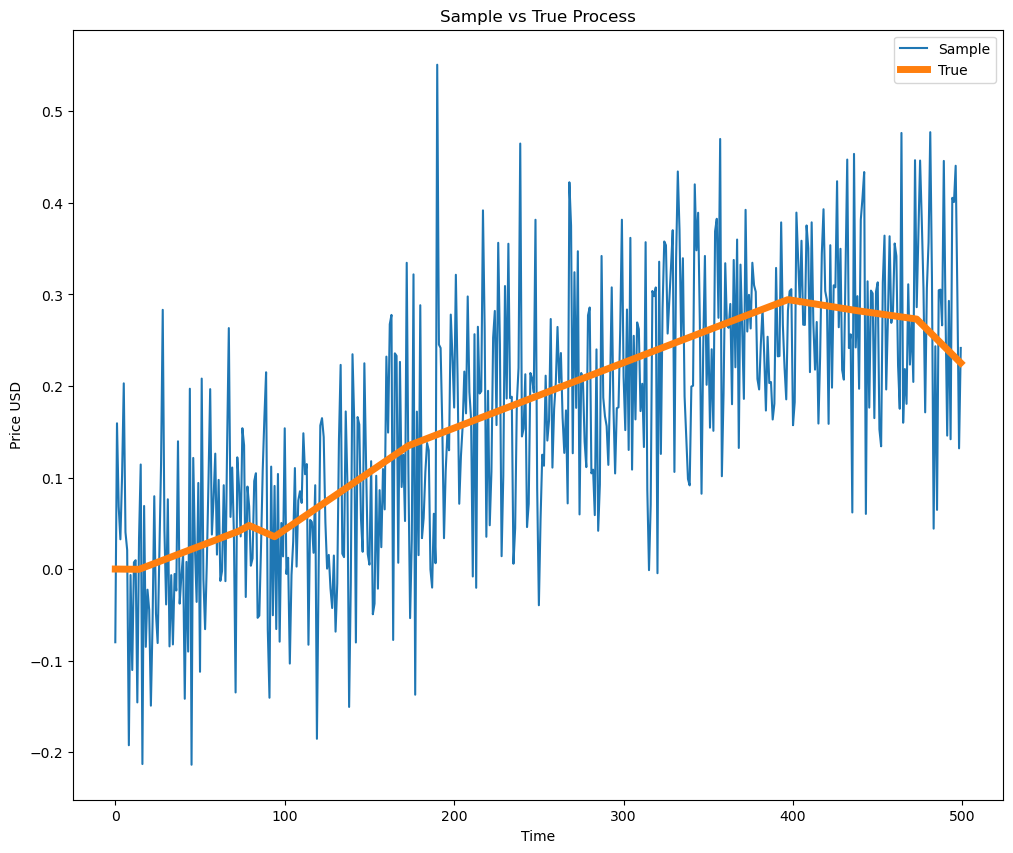

In [16]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(samples[1],label='Sample')
plt.plot(eval_true_linear[1],label='True',lw=5)
plt.xlabel("Time")
plt.ylabel("Price USD")
plt.title("Sample vs True Process")
plt.legend()

### Numerical Results 1; L1 trend filtering 

- Given the simulated path from step 5; we wish to apply L1 trend filtering to the problem
- Incorporates irregular spacing between observations
- Constrains our estimator to be piecewise linear 
- Here the penalty is set to the optimal constant determined via cross validation
    - Some lambda values in cross validation do not lead to convergence 

In [26]:
D=Difference_Matrix(len(volume_prior),2)
T=Time_Difference_Matrix(D,volume_index)

lambda_max=compute_lambda_max(T,time=True)

In [27]:
print(lambda_max)

70.71067811865468


In [28]:
lambda_grid=np.geomspace(0.00001,lambda_max,10)

optimal_lambda,optimal_error=cross_validation(samples[1].reshape(-1,1),D,grid=lambda_grid,t=volume_index,verbose=False)

print(f"Optimal Lambda is {optimal_lambda} and Optimal Error is {optimal_error}")


Optimal Lambda is 70.71067811865468 and Optimal Error is 4.757003733146803e-07


In [29]:
start_time=time.time()

results=adaptive_tf(samples[1].reshape(-1,1),D,t=volume_index,lambda_p=np.array([optimal_lambda]),verbose=True)

end_time=time.time()
print (f"Adaptive Trend Filtering took {end_time-start_time} seconds")


Adaptive Trend Filtering took 0.40445375442504883 seconds


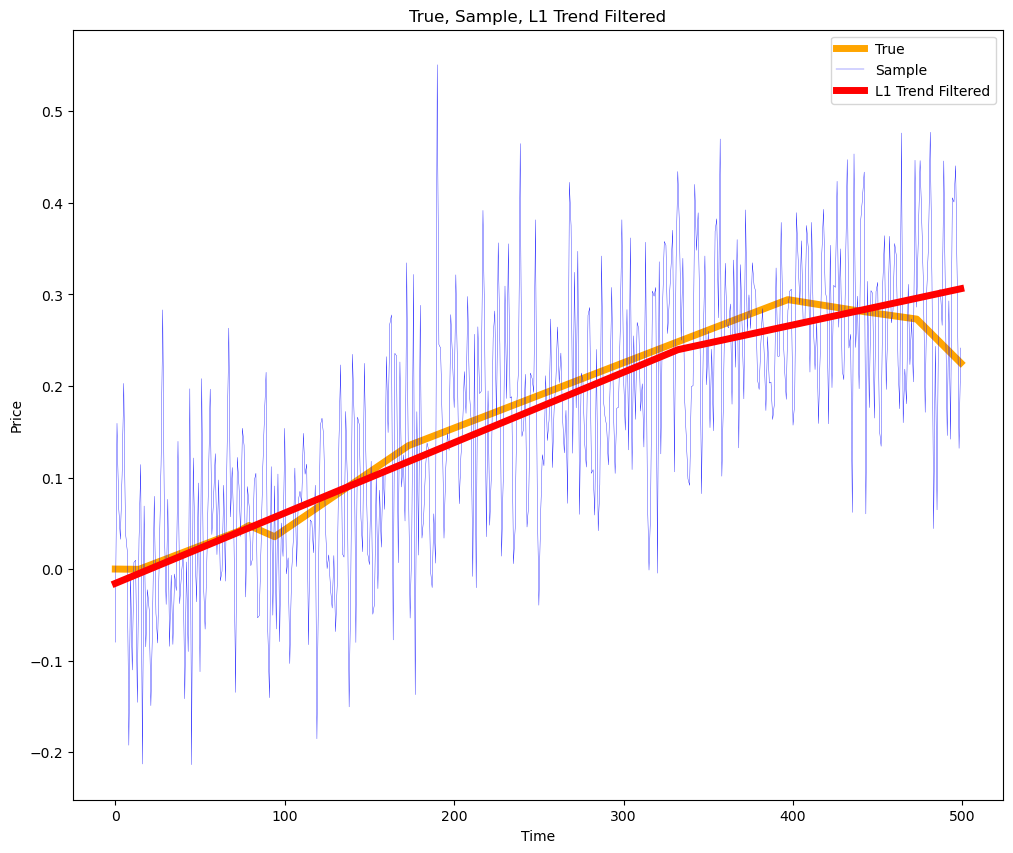

In [30]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(eval_true_linear[1],label='True', lw=5,color='orange')
plt.plot(samples[1],label='Sample',color='blue',lw=0.25)
plt.plot(results['sol'],label='L1 Trend Filtered',lw=5,color='red')
plt.title("True, Sample, L1 Trend Filtered")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

### Numerical Result 1; Conditional Adaptive L1 trend filtering  
- Estimator is piecewise linear accounting for irregular observations
- Sensitivity of estimator to changes in underlying trend is conditional on inverse of prior 
- Included explicitly as adaptive penalty (scaled by scale_factor)

In [50]:
def compute_scale_factor(robust_smooth_volume,optimal_lambda):
    """ Compute scale factor for adaptive l1 trend filtering
    """

    mean_smooth_volume=np.mean(1/robust_smooth_volume)


    scale_factor=optimal_lambda/mean_smooth_volume

    
    return scale_factor



scale_factor=compute_scale_factor(smooth,optimal_lambda) 
print(f"Optimal Scale Factor is {scale_factor}") 

adaptive_results=adaptive_tf(samples[1].reshape(-1,1),D,t=volume_index,lambda_p=scale_factor*1/smooth[1:-1].reshape(-1,1))


Optimal Scale Factor is 19158.399385898585


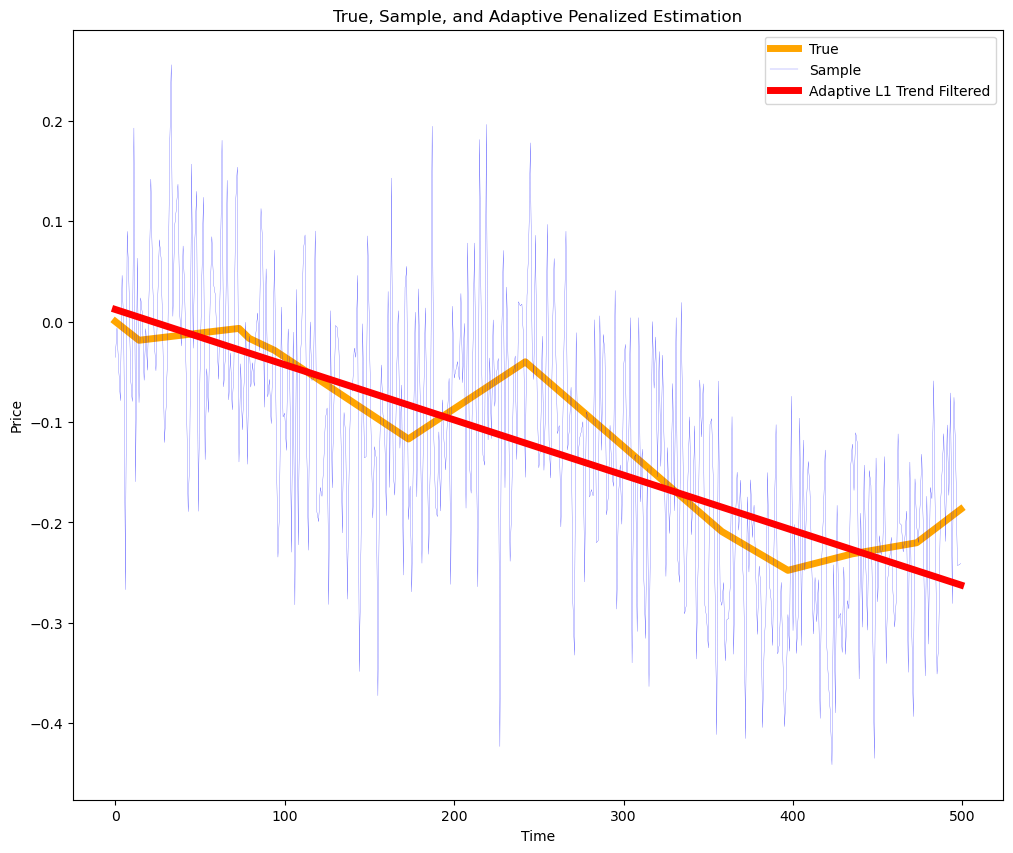

In [51]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(eval_true_linear[1],label='True', lw=5,color='orange')
plt.plot(samples[1],label='Sample',color='blue',lw=0.15)
plt.plot(results['sol'],label='Adaptive L1 Trend Filtered',lw=5,color='red')
plt.title("True, Sample, and Adaptive Penalized Estimation")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

### Step 7; Changepoint Extraction

- As estimator is piecweise linear; changepoints can be recovered in both simulations with second order difference operator
- Recovered changepoints plotted below; marked in black
- Threshold for occurrence of changepoint is another hyperparameter to be tuned

In [52]:
def extract_cp(smooth, k=2, threshold=1e-18):
    """ Extract changepoints via difference operator 
    """
    n = len(smooth)
    diff_mat = Difference_Matrix(n, k)
    D=diff_mat.D
    diff = np.dot(D, smooth).reshape(1, -1)[0]

    x, index = np.where([abs(diff) > threshold])
    return index

In [53]:
changepoints=extract_cp(results['sol'],threshold=1e-8)
adaptive_changepoints=extract_cp(adaptive_results['sol'],threshold=1e-8)

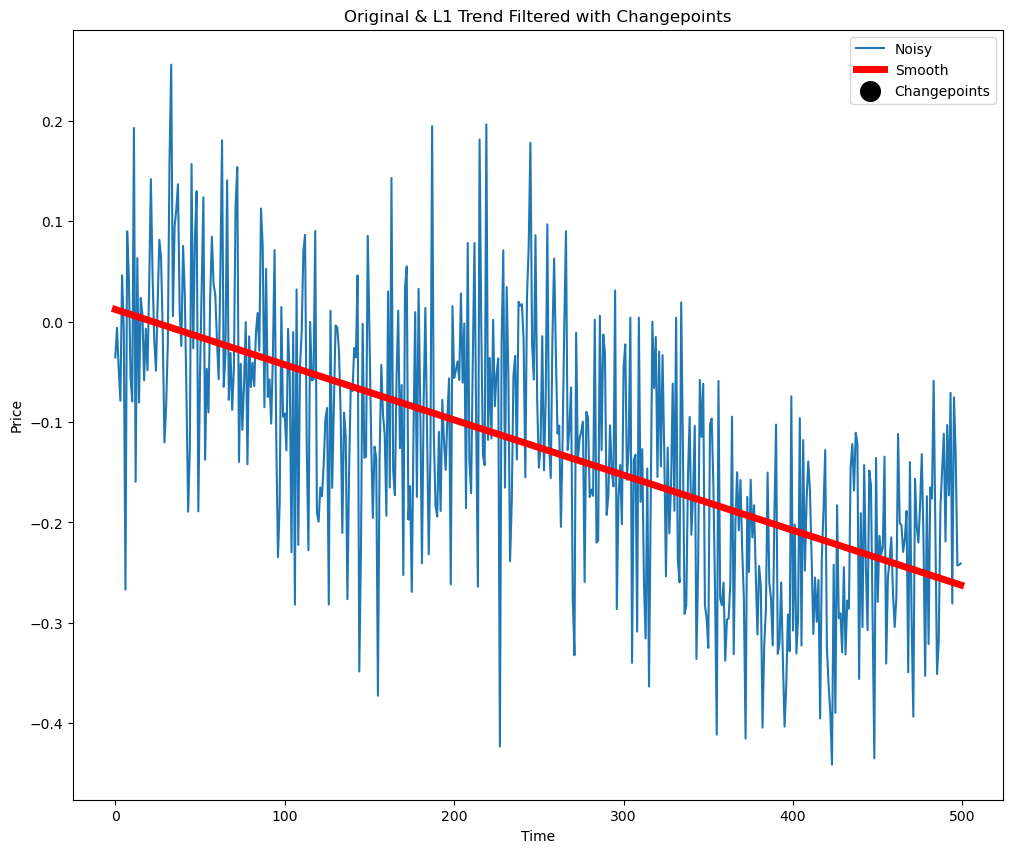

In [54]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(samples[1],label='Noisy')
plt.plot(results['sol'],label='Smooth',lw=5,color='red')
plt.scatter(np.arange(0,len(samples[1]),1)[changepoints],results['sol'][changepoints],color='black',s=200,label='Changepoints')
plt.title("Original & L1 Trend Filtered with Changepoints")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

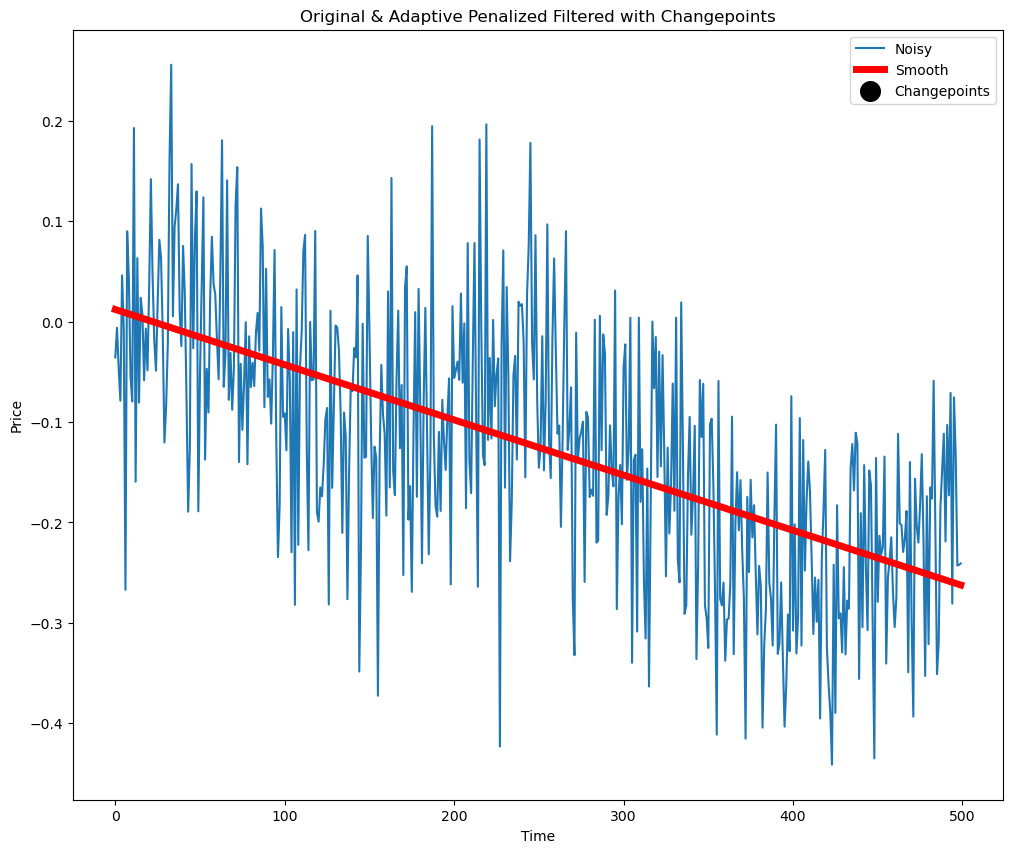

In [55]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(samples[1],label='Noisy')
plt.plot(adaptive_results['sol'],label='Smooth',lw=5,color='red')
plt.scatter(np.arange(0,len(samples[1]),1)[adaptive_changepoints],adaptive_results['sol'][adaptive_changepoints],color='black',s=200,label='Changepoints')
plt.title("Original & Adaptive Penalized Filtered with Changepoints")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

### Pruning Candidate Set

- Given our candidate set utilize dynamic programming to recursively find optimal changepoints for fixed k_i


In [56]:
potential_trend_cp=dp_solver(samples[1],changepoints,K_max=5)
potential_adaptive_trend_cp=dp_solver(samples[1],adaptive_changepoints,K_max=5)
potential_trend_cp


K_max must be less than or equal to the number of candidate changepoints
Candidate Indices are [  0 500]
K_max must be less than or equal to the number of candidate changepoints
Candidate Indices are [  0 500]


{0: [0]}

### Model Selection
- Utilize GCV score to determine optimal model (scaled mse)

In [57]:
optimal_trend_cp_mse,optimal_trend_cp_gcv=generalized_cross_validation(samples[1],potential_trend_cp)
optimal_adaptive_trend_cp_mse,optimal_adaptive_trend_cp_gcv=generalized_cross_validation(samples[1],potential_adaptive_trend_cp)

opt_cp_1=potential_trend_cp[optimal_trend_cp_gcv[0][0]]
opt_cp_2=potential_adaptive_trend_cp[optimal_adaptive_trend_cp_gcv[0][0]]

print(f"Optimal Trend Changepoints are {opt_cp_1} with error {optimal_trend_cp_gcv[0][1]}")
print(f"Optimal Adaptive Trend Changepoints are  {opt_cp_2} with error {optimal_adaptive_trend_cp_gcv[0][1]}")

Optimal Trend Changepoints are [0] with error 0.01069154572270123
Optimal Adaptive Trend Changepoints are  [0] with error 0.01069154572270123


### Continuity Correction via Linear Splines
- Interpretation is that this is the best linear piecewise continuous estimator given our changepoints

In [58]:
optimal_lin_splines=fit_linear_spline(samples[1],opt_cp_1)
optimal_adaptive_lin_splines=fit_linear_spline(samples[1],opt_cp_2)


ValueError: Interior knots t must satisfy Schoenberg-Whitney conditions

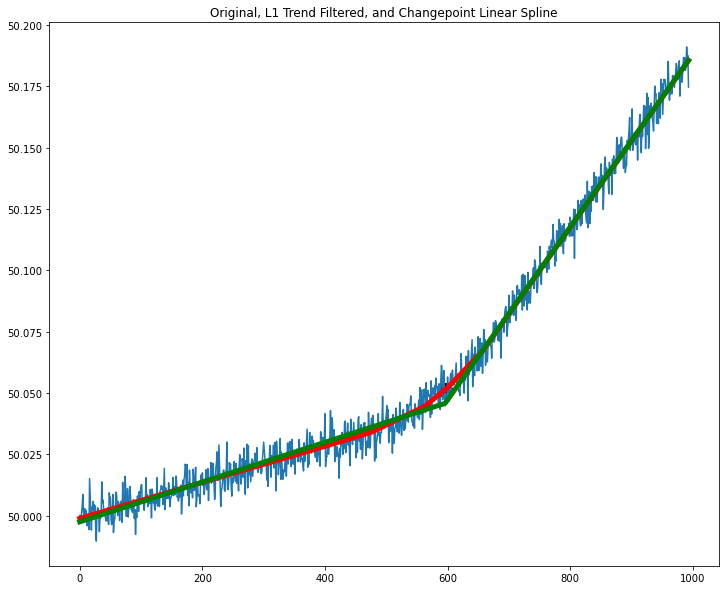

In [ ]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Original, L1 Trend Filtered, and Changepoint Linear Spline")
plt.plot(samples[1],label='Noisy')
plt.plot(trend_filter_series,label='Smooth',lw=5,color='red')
plt.plot(optimal_lin_splines,label='Linear Spline',lw=5,color='green')
plt.scatter(np.arange(0,len(samples[1]),1)[opt_cp_1],trend_filter_series[opt_cp_1],color='black',s=200,label='Optimal Changepoints')

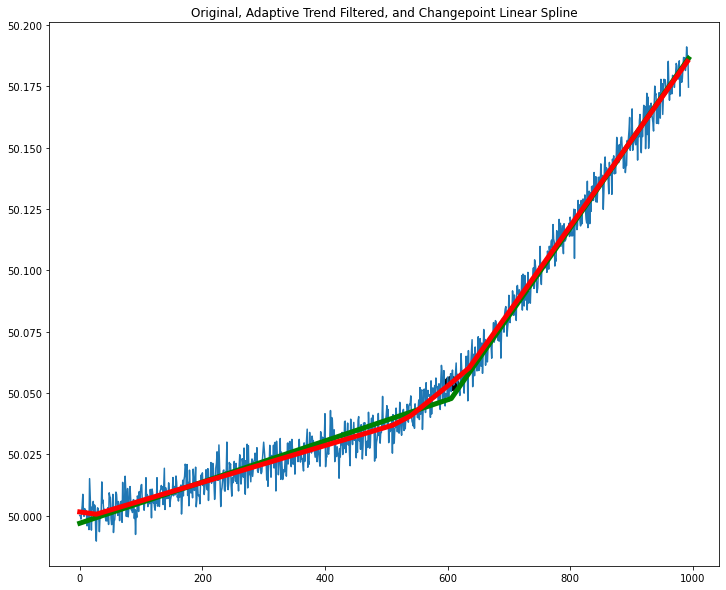

In [ ]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Original, Adaptive Trend Filtered, and Changepoint Linear Spline")
plt.plot(samples[1],label='Noisy')
plt.plot(optimal_adaptive_lin_splines,label='Linear Spline',lw=5,color='green')
plt.plot(adaptive_trend_filter_series,label='Smooth',lw=5,color='red')
plt.scatter(np.arange(0,len(samples[1]),1)[opt_cp_2],adaptive_trend_filter_series[opt_cp_2],color='black',s=200,label='Optimal Changepoints')